In [1]:
import numpy as np # linear algebra
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler, ConcatDataset
from torch import nn, optim
import torch 
import copy
from sklearn.model_selection import train_test_split

from torchvision import transforms, datasets
import timm 
import timm.optim
from timm.data.transforms_factory import create_transform
from torch.optim import lr_scheduler
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

def mediapipeimg(image):

  with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5) as hands:
    results = hands.process(image)
    # print('Handedness:', results.multi_handedness)



    image_height, image_width, _ = image.shape
    annotated_image = image.copy()

    landmark_tangan=[]
    for hand_landmarks in results.multi_hand_landmarks:
     
      mp_drawing.draw_landmarks(
          annotated_image,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())
    
    for hand_world_landmarks in results.multi_hand_world_landmarks:
      fitur = []
      data = []
      for h in range(0,20):
          x = hand_world_landmarks.landmark[h].x
          y = hand_world_landmarks.landmark[h].y
          z = hand_world_landmarks.landmark[h].z
          fitur.append(x)
          fitur.append(y)
          fitur.append(z)
      data.extend(fitur)
      x = 0
      y = 0
      z = 0



    return results, annotated_image, data

In [3]:
import cv2
import math
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import torchvision.transforms as T


base_options = python.BaseOptions(model_asset_path='gesture_recognizer.task')
options = vision.GestureRecognizerOptions(base_options=base_options)
recognizer = vision.GestureRecognizer.create_from_options(options)



def handGesture(img):
    landmarks = []
    errr = None
    # image = mp.Image.create_from_file(img)
    imgPil = T.ToPILImage()(img)
        
    medPil = mp.Image(
            image_format=mp.ImageFormat.SRGB, data=np.asarray(imgPil))
    recognition_result = recognizer.recognize(medPil)
    hand_landmarks = recognition_result.hand_landmarks
    if(len(hand_landmarks) != 0):
        for a in range(0,len(hand_landmarks[0])):
            x = hand_landmarks[0][a].x
            y = hand_landmarks[0][a].y
            z = hand_landmarks[0][a].z
            landmarks.append(x)
            landmarks.append(y)
            landmarks.append(z)
        errr = None
        return landmarks, errr
    else:
        errr = 1
        return landmarks, errr



In [4]:
def handGestureRec(img):
    landmarks = []
    errr = None
    image = mp.Image.create_from_file(img)
    # imgPil = T.ToPILImage()(img)
        
    # medPil = mp.Image(
    #         image_format=mp.ImageFormat.SRGB, data=np.asarray(imgPil))
    recognition_result = recognizer.recognize(image)
    hand_landmarks = recognition_result.hand_landmarks
    if(len(hand_landmarks) != 0):
        for a in range(0,len(hand_landmarks[0])):
            x = hand_landmarks[0][a].x
            y = hand_landmarks[0][a].y
            z = hand_landmarks[0][a].z
            landmarks.append(x)
            landmarks.append(y)
            landmarks.append(z)
        errr = None
        return landmarks, errr
    else:
        errr = 1
        return landmarks, errr

imgUri = "asl_dataset/3/hand1_3_bot_seg_5_cropped.jpeg"
# imageRec = mp.Image.create_from_file(imgUri)
tesRec, errRec = handGestureRec(imgUri)
print(len(tesRec))

63


In [5]:
import cv2 
imgMed = Image.open("asl_dataset/0/hand1_0_bot_seg_1_cropped.jpeg")
imgMed = np.array(imgMed)
imgMedCv = cv2.imread("asl_dataset/0/hand1_0_bot_seg_1_cropped.jpeg")
medResult, anotatedImg, dataResult = mediapipeimg(imgMed)
print(len(dataResult))
print(type(dataResult))
dtr = torch.Tensor(dataResult)
dmm = dtr.unsqueeze(0)
print(type(dtr), dmm.shape)
data = torch.randn(1, 10)
print(type(data), data.shape)


    
        
# print(type(imgMed))
# print(type(imgMedCv))



60
<class 'list'>
<class 'torch.Tensor'> torch.Size([1, 60])
<class 'torch.Tensor'> torch.Size([1, 10])


In [6]:
train_transform = transforms.Compose([
     transforms.RandomRotation(degrees=(30, 70)),
    transforms.Resize((100, 100)),
    # transforms.Grayscale(1),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
   
    transforms.ToTensor(),
   
])

train_transform2 = transforms.Compose([
    transforms.RandomRotation(degrees=(40, 50)),
    transforms.Resize((100, 100)),
    # transforms.Grayscale(1),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    
    transforms.ToTensor(),
   
])

train_transformOriginal = transforms.Compose([transforms.Resize((100, 100)),
                                            #   transforms.Grayscale(1),
                                              transforms.ToTensor()])

dtOri = datasets.ImageFolder(
    root="asl_dataset",
    transform=train_transformOriginal
)

dt1 = datasets.ImageFolder(
    root="asl_dataset",
    transform=train_transform
)

dt2 = datasets.ImageFolder(
    root="asl_dataset",
    transform=train_transform2
)

dtConcat = ConcatDataset([dtOri, dt1, dt2])

print(len(dtOri.class_to_idx))
print(len(dtConcat))

36
7545


In [7]:
idx_to_class = {v: k for k, v in dtOri.class_to_idx.items()}

def get_class_distribution(dataset):
    count_dict = {k:0 for k,v in dtOri.class_to_idx.items()} # initialise dictionary
    
    for input, label in dataset:
        label = idx_to_class[label]
        count_dict[label] += 1
            
    return count_dict

print("Distribution of classes: ", get_class_distribution(dtConcat))

get_class_distribution(dtConcat)

Distribution of classes:  {'0': 210, '1': 210, '2': 210, '3': 210, '4': 210, '5': 210, '6': 210, '7': 210, '8': 210, '9': 210, 'a': 210, 'b': 210, 'c': 210, 'd': 210, 'e': 210, 'f': 210, 'g': 210, 'h': 210, 'i': 210, 'j': 210, 'k': 210, 'l': 210, 'm': 210, 'n': 210, 'o': 210, 'p': 210, 'q': 210, 'r': 210, 's': 210, 't': 195, 'u': 210, 'v': 210, 'w': 210, 'x': 210, 'y': 210, 'z': 210}


{'0': 210,
 '1': 210,
 '2': 210,
 '3': 210,
 '4': 210,
 '5': 210,
 '6': 210,
 '7': 210,
 '8': 210,
 '9': 210,
 'a': 210,
 'b': 210,
 'c': 210,
 'd': 210,
 'e': 210,
 'f': 210,
 'g': 210,
 'h': 210,
 'i': 210,
 'j': 210,
 'k': 210,
 'l': 210,
 'm': 210,
 'n': 210,
 'o': 210,
 'p': 210,
 'q': 210,
 'r': 210,
 's': 210,
 't': 195,
 'u': 210,
 'v': 210,
 'w': 210,
 'x': 210,
 'y': 210,
 'z': 210}

Text(0.5, 1.0, 'Class Distribution of the ASL static Dataset')

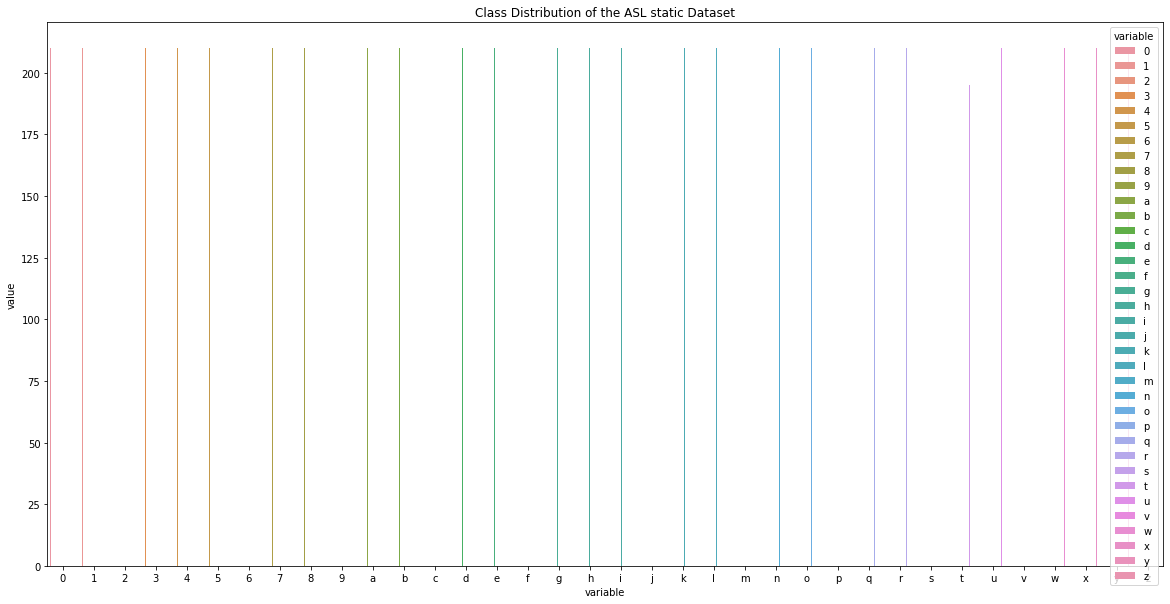

In [8]:
plt.figure(figsize=(20, 10))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(dtConcat)]).melt(), 
            x = "variable", y="value", hue="variable").set_title('Class Distribution of the ASL static Dataset')

In [9]:
train_dataset, val_dataset, test_dataset = random_split(dtConcat, (5000, 1250, 1295))
print(len(dtConcat)) # length of the dataset
print(len(train_dataset)) # length of the train division
print(len(val_dataset)) # length of the validation division
print(len(test_dataset)) # length of the test division


7545
5000
1250
1295


In [10]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=1, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=1)

print("Length of the train_loader:", len(train_loader))
print("Length of the val_loader:", len(val_loader))
print("Length of the test_loader:", len(test_loader))

Length of the train_loader: 5000
Length of the val_loader: 1250
Length of the test_loader: 1295


Text(0.5, 1.0, 'Test Set')

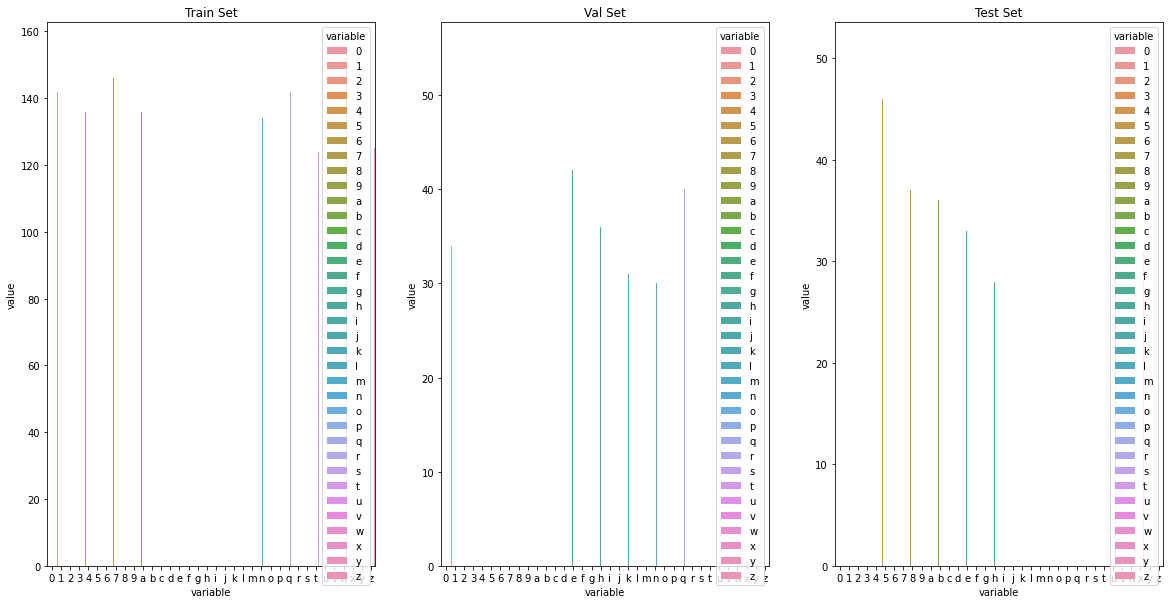

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(train_dataset)]).melt(),
            x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Train Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(val_dataset)]).melt(), 
            x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Val Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(test_dataset)]).melt(),
            x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Test Set')

C:\Users\intel\AppData\Local\Temp\ipykernel_13640\2372025784.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2318.)
  ax[0,i].imshow(image.T, cmap="magma") # Squeeze removes length (1,28,28) -> (28,28)


Text(0, 0.5, 'Original Images')

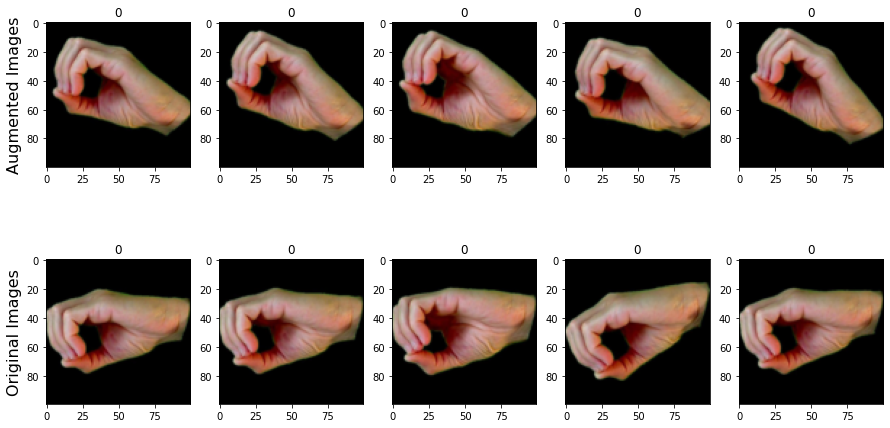

In [12]:
#Visualizing some examples in the training dataset X
fig, ax = plt.subplots(nrows = 2, ncols = 5,  figsize = (15,8))
for i in range(5):
    image, y = dt1.__getitem__(i)
    ax[0,i].imshow(image.T, cmap="magma") # Squeeze removes length (1,28,28) -> (28,28)
    ax[0,i].set_title(int(y))
    
    image, y = dtOri.__getitem__(i)
    ax[1,i].imshow(image.T, cmap="viridis") # Squeeze removes length (1,28,28) -> (28,28)
    ax[1,i].set_title(int(y))

ax[0,0].set_ylabel('Augmented Images',fontdict= {'fontsize':16})
ax[1,0].set_ylabel('Original Images', fontdict= {'fontsize':16})

In [13]:
timm.list_models('resnet*',pretrained=True)

['resnet10t.c3_in1k',
 'resnet14t.c3_in1k',
 'resnet18.a1_in1k',
 'resnet18.a2_in1k',
 'resnet18.a3_in1k',
 'resnet18.fb_ssl_yfcc100m_ft_in1k',
 'resnet18.fb_swsl_ig1b_ft_in1k',
 'resnet18.gluon_in1k',
 'resnet18.tv_in1k',
 'resnet18d.ra2_in1k',
 'resnet26.bt_in1k',
 'resnet26d.bt_in1k',
 'resnet26t.ra2_in1k',
 'resnet32ts.ra2_in1k',
 'resnet33ts.ra2_in1k',
 'resnet34.a1_in1k',
 'resnet34.a2_in1k',
 'resnet34.a3_in1k',
 'resnet34.bt_in1k',
 'resnet34.gluon_in1k',
 'resnet34.tv_in1k',
 'resnet34d.ra2_in1k',
 'resnet50.a1_in1k',
 'resnet50.a1h_in1k',
 'resnet50.a2_in1k',
 'resnet50.a3_in1k',
 'resnet50.am_in1k',
 'resnet50.b1k_in1k',
 'resnet50.b2k_in1k',
 'resnet50.bt_in1k',
 'resnet50.c1_in1k',
 'resnet50.c2_in1k',
 'resnet50.d_in1k',
 'resnet50.fb_ssl_yfcc100m_ft_in1k',
 'resnet50.fb_swsl_ig1b_ft_in1k',
 'resnet50.gluon_in1k',
 'resnet50.ra_in1k',
 'resnet50.ram_in1k',
 'resnet50.tv2_in1k',
 'resnet50.tv_in1k',
 'resnet50_gn.a1h_in1k',
 'resnet50c.gluon_in1k',
 'resnet50d.a1_in1k',
 '

In [14]:
# intermediete layer

modelTes = timm.create_model('resnet10t.c3_in1k', pretrained=False)
modelTes.fc = nn.Linear(modelTes.fc.in_features, modelTes.fc.out_features)
features = {}

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

modelTes.global_pool.register_forward_hook(get_features('global_pool'))
imgg = Image.open("asl_dataset/0/hand1_0_bot_seg_1_cropped.jpeg")
convert_tensor = transforms.ToTensor()
imgg = convert_tensor(imgg)
mdt = modelTes(imgg.unsqueeze(0))
print(mdt.shape)

torch.Size([1, 1000])


In [15]:
# concatenate layer

import torch.nn.functional as F
from torchsummary import summary
from torchvision import models as models

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cnn = timm.create_model('resnet10t.c3_in1k', pretrained=True, num_classes=36)
        self.cnn.fc = nn.Linear(
            self.cnn.fc.in_features, self.cnn.fc.out_features)
        
        self.fc1 = nn.Linear(20 + 79, 60)
        self.fc2 = nn.Linear(60, 40)
        self.fc3 = nn.Linear(40,36)
        
    def forward(self, image, data):
        x1 = self.cnn(image)
        x2 = data
        
        x = torch.cat((x1.detach(), x2), dim=1)
        # x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
        
class MyModelDefault(nn.Module):
    def __init__(self):
        super(MyModelDefault, self).__init__()
        self.cnn = timm.create_model('resnet10t.c3_in1k', pretrained=True, num_classes = 36)
        self.cnn.fc = nn.Linear(
            self.cnn.fc.in_features, 500
        )
        self.fc1 = nn.Linear(self.cnn.fc.out_features + 63, 300)
        self.fc2 = nn.Linear(300, 36)
    def forward(self, image, data):
        x1 = self.cnn(image)
        x2 = data
        x = torch.cat((x1, x2), dim=1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MyModelDefault()
model

# batch_size = 1
# image = torch.randn(batch_size, 3, 299, 299)
# # data = torch.randn(batch_size, 10)
# aa,bb,cc = mediapipeimg(imgMed)
# cc = torch.Tensor(cc)
# ccA = cc.unsqueeze(0)
# print("data", cc)
# print("cca shape",ccA.shape)
# output = model(image, ccA)
# # summary(model((1,3,100,100),(1,60)).cuda(), input_size=[(91,3,100,100), (1,60)])
# output

MyModelDefault(
  (cnn): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [16]:
# from torch import tensor
# import torchvision.transforms as T
# from PIL import Image as im 
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0001)
# running_loss = 0.0

# trainingEpoch_loss = []
# validationEpoch_loss = []

# for epoch in range(30):
#     for i, data in enumerate(train_loader, 0):
#         inputsImg, labels = data
#         for img in inputsImg:
            
#             recognition_result, err = handGesture(img)
#             # print(len(recognition_result))
#             if (err == None):
                
#                 # print(torch.as_tensor(recognition_result))
#                 tensor_recognitionResult = torch.as_tensor(recognition_result)
#                 tensor_recogAddElement = torch.unsqueeze(tensor_recognitionResult, dim=0)
#                 # print(tensor_recogAddElement.shape)
#                 # tensor_recogAddElement = tensor_recogAddElement.expand(32, -1)
#                 # tensor_recogAddElement[0] = 32
#                 # print(tensor_recogAddElement)
                
                
#                 optimizer.zero_grad()
#                 outputs = model(inputsImg, tensor_recogAddElement)
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()
#                 # writer.add_scalar("Loss/train", loss, epoch)
#                 running_loss += loss.item()
#                 # if i % 1000 == 999:    # print every 2000 mini-batches
#                     # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                   
#             else:
#                 # print("haah kosong")
#                 continue
#     trainingEpoch_loss.append(running_loss/1000)
#     print(running_loss/1000)
#     running_loss = 0.0
    
    
        

        
    
    

In [17]:
# from matplotlib import pyplot as plt
# plt.plot(trainingEpoch_loss, label='train_loss')
# # plt.plot(validationEpoch_loss,label='val_loss')
# plt.legend()
# plt.show

In [20]:
class MyModelDefaultnoConcat(nn.Module):
    def __init__(self):
        super(MyModelDefaultnoConcat, self).__init__()
        self.cnn = timm.create_model('resnet10t.c3_in1k', pretrained=True)
        
       
        self.fc1 = nn.Linear(1000, 36)
    def forward(self, image):
        x = self.cnn(image)
        x = self.fc1 (x)
        
        
        return x

modelnoConcat = MyModelDefaultnoConcat()
modelnoConcat

MyModelDefaultnoConcat(
  (cnn): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [21]:
from torch import tensor
import torchvision.transforms as T
from PIL import Image as im 
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0001)
running_loss = 0.0

trainingEpoch_loss = []
validationEpoch_loss = []

for epoch in range(30):
    for i, data in enumerate(train_loader, 0):
        inputsImg, labels = data
                      
        optimizer.zero_grad()
        outputs = modelnoConcat(inputsImg)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
                # writer.add_scalar("Loss/train", loss, epoch)
        running_loss += loss.item()
                # if i % 1000 == 999:    # print every 2000 mini-batches
                    # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                   
            
    trainingEpoch_loss.append(running_loss/1000)
    print(running_loss/1000)
    running_loss = 0.0
    
    
        

        
    
    

18.742233320713044
18.770644337654115
18.731042946815492


KeyboardInterrupt: 

In [ ]:
# import torchvision.transforms as T

# for i, data in enumerate(train_loader, 0):
#     inputs, labels = data
#     for img in inputs:
#         transform = T.ToPILImage()
#         image = transform(img)
#         imageArray = np.array(image)
#         plt.imshow(imageArray)
#         aa = handGesture(imageArray)
#         print(aa)
#         # inputsRGB = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
#     # inputsRGB = cv2.cvtColor(inputs, cv2.COLOR_GRAY2RGB)
#     # print(inputsRGB.shape)
#     # aa, bb, cc = mediapipeimg(inputs)
#     # print(cc.shape)
# # print(type(imageRGB))
# # print(imageRGB)
# # imgMed = Image.open("asl_dataset/0/hand1_0_bot_seg_1_cropped.jpeg")
# # imgMed = np.array(imgMed)
# # a,b,c = mediapipeimg(imgMed)
# # print(c)




In [ ]:
# ll = 0
# mm = 0
# for i, data in enumerate(train_loader, 0):
#     inputs, labels = data
#     # print(len(inputs))
#     for a in inputs:
#         ll = ll+1
#         # print("input", a.size())
#         if(a == None):
#             print("kosong")
#         # print(a.size())
#     mm = mm+1
#     # print("data", mm)

In [ ]:
# # train 
# import torchvision.transforms as T


# import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# for epoch in range(2):  # loop over the dataset multiple times
#      # zero the parameter gradients
#     optimizer.zero_grad()

#     # forward + backward + optimize
   
    

#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         for img in inputs:
#             transform = T.ToPILImage()
#             image = transform(img)
#             image = np.array(image)
#             # print(image.shape)
#             inputsRGB = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#             try:
#                 aa = handGesture(inputsRGB)
#                 # print("train ke", i+1)
#                 outputs = model(inputs, aa)
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()
                
#                 running_loss += loss.item()
#                 # if i % 2000 == 1999:    # print every 2000 mini-batches
#                 print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#                 running_loss = 0.0
                
#             except:
#                 print("ada error")
#                 continue
# print('Finished Training')


